In [12]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import joblib  # Để lưu mô hình RandomForest

In [14]:
# Hàm tải dữ liệu ảnh và gán nhãn từ thư mục
def load_images_from_folder(folder, image_size=(128, 128)):
    images = []
    labels = []
    label_map = {}  # Map để theo dõi tên thư mục và nhãn của chúng
    label_idx = 0

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label_map[label_idx] = subfolder  # Ánh xạ mã số lớp với tên lớp (cat or dog)
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                try:
                    img = Image.open(img_path)
                    img = img.resize(image_size)  # Resize hình ảnh về kích thước 128x128
                    img = np.array(img).flatten()  # Chuyển đổi ảnh thành vector phẳng
                    images.append(img)
                    labels.append(label_idx)  # Gán nhãn dựa trên thư mục (cat or dog)
                except:
                    continue
            label_idx += 1

    images = np.array(images) / 255.0  # Chuẩn hóa dữ liệu hình ảnh
    return images, np.array(labels), label_map

In [16]:
# Đường dẫn đến thư mục train và test
train_folder = "data/train"
test_folder = "data/test"

# Tải dữ liệu huấn luyện và kiểm tra
X, y, label_map = load_images_from_folder(train_folder, image_size=(128, 128))  # Sử dụng kích thước 128x128

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Hàm lấy các mẫu dữ liệu ngẫu nhiên với phần tử có thể lặp lại
def bootstrap(X, y):
    n_sample = X.shape[0]
    _id = np.random.choice(n_sample, n_sample, replace=True)
    return X[_id], y[_id]  # Sử dụng slicing của numpy

In [20]:
# Lớp RandomForest
class RandomForest:
    def __init__(self, n_trees=5, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          min_samples_split=self.min_samples_split,
                                          max_features=self.n_features)
            X_sample, y_sample = bootstrap(X, y)  # Sử dụng hàm bootstrap
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        if predictions.shape[0] == 0:
            raise ValueError("No predictions were made. Check the input data.")
        final_pred = [np.bincount(sample_pred).argmax() for sample_pred in predictions.T]  # Bỏ qua vòng lặp i
        return np.array(final_pred)


In [22]:
# Hàm tính độ chính xác (accuracy)
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


In [24]:
# Huấn luyện mô hình RandomForest
randomForest = RandomForest(n_trees=3, n_features=4)  # Khởi tạo với 3 cây và 4 đặc trưng
randomForest.fit(X_train, y_train)

In [26]:
# Dự đoán với tập dữ liệu kiểm tra
y_pred = randomForest.predict(X_test)

# Tính độ chính xác và các chỉ số khác
acc = accuracy(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
# In các kết quả
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# In ra nhãn của các lớp
print("Label map (Class index -> Class name):", label_map)

Accuracy: 0.6998484082870137
Precision: 0.7005025680175041
Recall: 0.6998484082870137
F1 Score: 0.7000354620655493
Confusion Matrix:
 [[736 311]
 [283 649]]
Label map (Class index -> Class name): {0: 'cat', 1: 'dog'}


In [30]:
# Lưu mô hình RandomForest vào tệp
def save_model(model, filename):
    joblib.dump(model, filename)  # Lưu mô hình vào tệp .pth (hoặc tệp .pkl)
    print(f'Model saved as {filename}')

# Lưu mô hình với đuôi .pth (hoặc .pkl)
save_model(randomForest, 'random_forest_model.pth')

Model saved as random_forest_model.pth


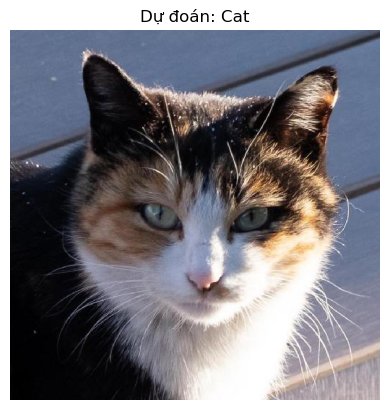

In [36]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Bản đồ nhãn
label_map = {0: "Cat", 1: "Dog"}  # Thay bằng nhãn thực tế trong mô hình

# Hàm dự đoán từ ảnh do người dùng nhập
def predict_user_image(model, image_path, image_size=(128, 128)):
    try:
        # Mở ảnh
        img = Image.open(image_path)
        img_resized = img.resize(image_size)  # Resize ảnh cho đúng kích thước
        img_array = np.array(img_resized).flatten() / 255.0  # Chuẩn hóa hình ảnh
        img_array = img_array.reshape(1, -1)  # Thêm chiều batch

        # Dự đoán
        prediction = model.predict(img_array)
        class_name = label_map[prediction[0]]

        # Hiển thị ảnh và kết quả
        plt.imshow(img)
        plt.title(f"Dự đoán: {class_name}")
        plt.axis('off')  # Tắt trục
        plt.show()
    except Exception as e:
        print(f"Lỗi: {e}")

# Đường dẫn ảnh do người dùng nhập
user_image_path = "data/test/cat/flickr_cat_000056.jpg"

# Gọi hàm dự đoán và hiển thị
predict_user_image(randomForest, user_image_path)

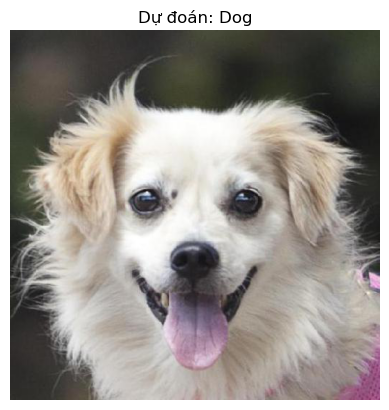

In [42]:
user_image_path = "data/test/dog/flickr_dog_000045.jpg"
predict_user_image(randomForest, user_image_path)